In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import datetime
from datetime import timedelta
import matplotlib.cm as cm

In [2]:
path = Path.cwd()
figure_path = path / 'Figures'

In [3]:
files = list((path / "Output").glob("*.nc"))

In [4]:
# files

In [5]:
ds = xr.open_dataset(files[0])

In [16]:
def plot_hydrograph(ds_combined, ax, summary_stat):
    NSE_mean = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat=summary_stat).values)
    NSE_mean_log = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat=summary_stat).values)
    
    ds_combined["Q_obs"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')
    
    ds_combined["Q"].sel(summary_stat=summary_stat).plot(ax=ax, color="C1",lw=0.5,label=f"NSE: {NSE_mean:.2f}\n   Log NSE: {NSE_mean_log:.2f}",zorder=-1)
    
    ax.fill_between(ds_combined.time, 
                             ds_combined["Q"].sel(summary_stat="min").values,
                             ds_combined["Q"].sel(summary_stat="max").values,color="C0", alpha=0.35,zorder=-10,label="bounds")
    n_particles = ds_combined.attrs['n_particles']
    ax.set_ylabel("Q [mm]")
    ax.set_title(f"Run ensemble of {n_particles} particles");
    return ax

In [17]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qo - Qm)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)
    
def calc_log_NSE(Qo, Qm):
    Qo[Qo == 0] = 1e-6
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((np.log(Qo) - np.log(Qm))**2)
    ErrDo = np.sum((np.log(Qo) - np.log(QoAv))**2)
    return 1 - (ErrUp / ErrDo)

In [18]:
df = pd.DataFrame(columns=["NSE_mean","NSE_mean_log","NSE_best","NSE_best_log","path"],)
for file in files:
    ds = xr.open_dataset(file)
    uid = ds.attrs['HRU_id']
    df.loc[uid, 'NSE_mean'] = calc_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="mean").values)
    df.loc[uid, 'NSE_mean_log'] = calc_log_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="mean").values)
    df.loc[uid, 'NSE_best'] = calc_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="best").values)
    df.loc[uid, 'NSE_best_log'] = calc_log_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="best").values)
    df.loc[uid,'path'] = file
    ds.close()

In [19]:
df.iloc[0].path

PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_42_also_store_Q_best/Output/01078000_psf-0.001_w-2_N-500_2024-05-28 02_36.nc')

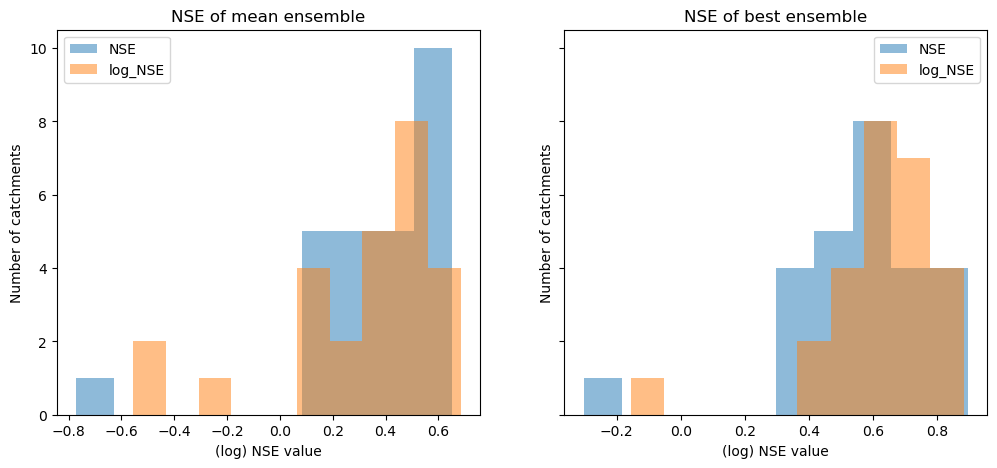

In [20]:
fig, axs = plt.subplots(1,2,sharey=True,figsize=(12,5))
ax = axs[0]
ax.hist(df['NSE_mean'],color="C0",alpha=0.5,label="NSE");
ax.hist(df['NSE_mean_log'],color="C1",alpha=0.5, label="log_NSE");
ax.legend()
ax.set_ylabel('Number of catchments')
ax.set_xlabel("(log) NSE value");
title = f"NSE of mean ensemble"
ax.set_title(title);

ax = axs[1]
ax.hist(df['NSE_best'],color="C0",alpha=0.5,label="NSE");
ax.hist(df['NSE_best_log'],color="C1",alpha=0.5, label="log_NSE");
ax.legend()
ax.set_ylabel('Number of catchments')
ax.set_xlabel("(log) NSE value");
title = f"NSE of best ensemble"
ax.set_title(title);


title = title.replace(" ", '_')
fig.savefig(figure_path / (title + 'png'))

In [21]:
ds = xr.open_dataset(df.loc['01073000','path'])

In [22]:
ds.attrs['HRU_id']

'01073000'

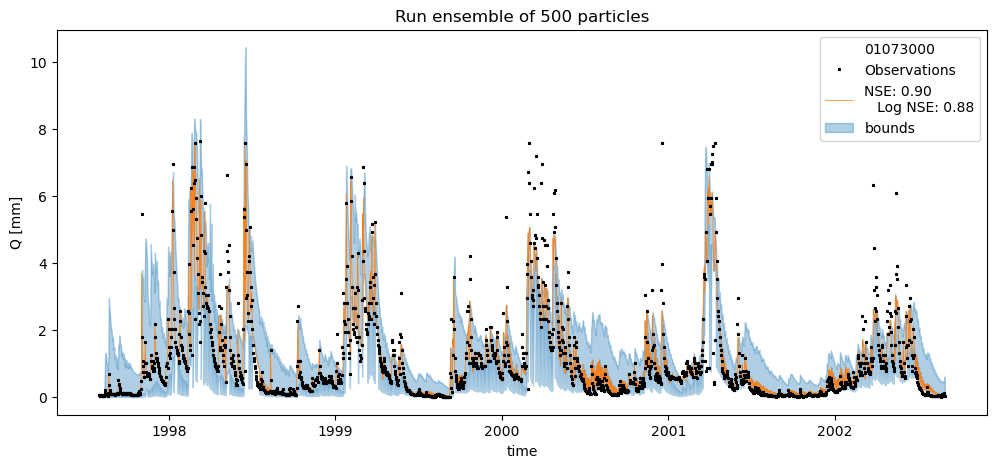

In [23]:
fig, ax = plt.subplots(1,1, figsize=(12,5),sharex=True)
ax = plot_hydrograph(ds, ax,'best')
ax.legend(title=ds.attrs['HRU_id'])

In [24]:
ds = xr.open_dataset(df.loc['01013500','path'])

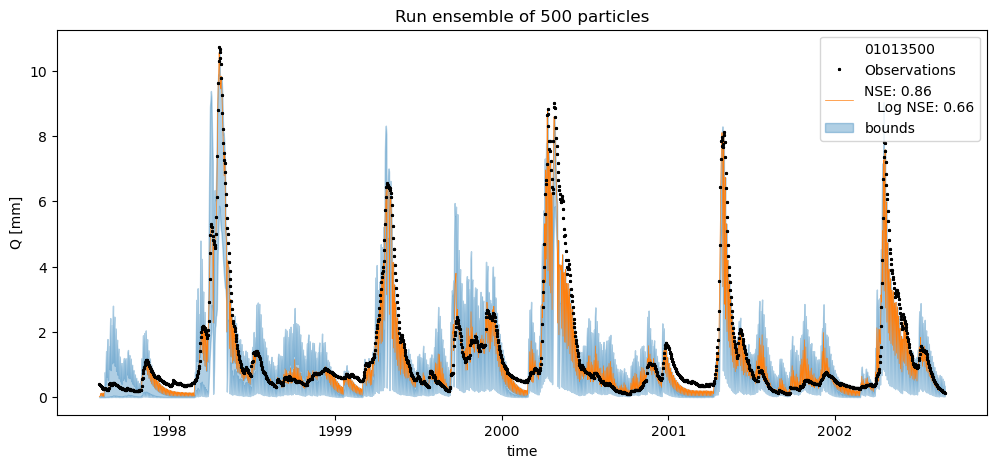

In [25]:
fig, ax = plt.subplots(1,1, figsize=(12,5),sharex=True)
ax = plot_hydrograph(ds, ax,'best')
ax.legend(title=ds.attrs['HRU_id'])